# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded_MPCC_P import VLE_block_rule
from physics.MPCC_P import P_NCP_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=3000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.P_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

In [10]:
model.VLE_block.pressure_equal_con.pprint()

pressure_equal_con : Size=1, Index=None, Active=True
    Key  : Lower : Body                : Upper : Active
    None :   0.0 : VLE_block.P_VLE - P :   0.0 :   True


## MPCC: Beta

In [11]:
model.MPCC = pe.Block(rule = P_NCP_block_rule)

> Importing MPCC_beta_NCP Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC.s_L
| MPCC.s_V
| MPCC.epi
--------------------------------------------------
> Adding complementarity constraint



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [12]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [13]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [14]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [15]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [16]:
model.cat.fix(3000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0/2)
model.z['H2'].fix(0.8/(1+0.8)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [17]:
check_DOF(pe,model)

Active Equality Constraints:	 1184
Active Inequality Constraints:	 0
Active Variables:		 1357
Fixed Variables:		 172
DOF:				 1


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [18]:
model.T.setub(300+273.15)

In [19]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.cat,sense=pe.minimize)
model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)

In [20]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
# opt.options['linear_solver'] = 'ma27'

# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
max_iter=7000


List of user-set options:

                                    Name   Value                used
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4016
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:

  75 -5.2752025e+02 3.43e-01 8.31e+06  -1.0 4.97e+02    -  1.00e+00 6.23e-02h  5
  76 -5.2770653e+02 3.38e-01 9.75e+06  -1.0 5.25e+02    -  9.42e-01 5.83e-02h  5
  77 -5.2789095e+02 3.34e-01 1.18e+07  -1.0 5.54e+02    -  1.00e+00 5.49e-02h  5
  78 -5.2807389e+02 3.31e-01 1.47e+07  -1.0 5.82e+02    -  9.46e-01 5.18e-02h  5
  79 -5.2825540e+02 3.29e-01 1.90e+07  -1.0 6.10e+02    -  1.00e+00 4.91e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -5.3114160e+02 3.68e+00 9.08e+08  -1.0 6.38e+02    -  9.50e-01 7.47e-01w  1
  81 -5.3134622e+02 3.58e+00 9.83e+08  -1.0 1.07e+03    -  2.22e-01 3.22e-02w  1
  82 -5.3204629e+02 3.07e+00 3.48e+09  -1.0 5.88e+02    -  2.64e-02 2.01e-01w  1
  83 -5.2843578e+02 3.27e-01 2.55e+07  -1.0 5.20e+02    -  9.50e-01 4.67e-02h  4
  84 -5.2861493e+02 3.27e-01 3.59e+07  -1.0 6.66e+02    -  1.00e+00 4.44e-02h  5
  85 -5.2879299e+02 3.27e-01 5.20e+07  -1.0 6.95e+02    -  9.52e-01 4.24e-02h  5
  86 -5.2888132e+02 3.23e-01

 169 -5.5103157e+02 2.79e-10 1.60e+11  -3.8 8.69e-09  19.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -5.5103157e+02 7.31e-10 1.60e+11  -5.7 1.30e-02    -  8.85e-03 1.44e-03h  4
 171 -5.5103157e+02 7.30e-10 1.60e+11  -5.7 6.83e-03    -  2.14e-01 4.97e-06h 13
 172r-5.5103157e+02 7.30e-10 1.00e+03  -5.7 0.00e+00    -  0.00e+00 4.24e-07R 12
 173r-5.5102764e+02 7.14e-06 5.82e+02  -5.7 1.57e+00    -  4.43e-01 4.63e-01f  1
 174r-5.5102682e+02 6.50e-06 5.32e+02  -5.7 1.14e+00    -  4.47e-01 1.32e-01h  1
 175r-5.5102157e+02 1.27e-05 1.62e+02  -5.7 9.74e-01    -  7.83e-01 1.00e+00h  1
 176r-5.5102422e+02 2.36e-05 6.02e+01  -5.7 4.90e-01    -  7.39e-01 1.00e+00h  1
 177r-5.5102749e+02 2.36e-05 9.10e+01  -5.7 6.08e-01    -  7.42e-01 1.00e+00h  1
 178r-5.5103234e+02 3.21e-05 2.03e+02  -5.7 8.98e-01    -  5.17e-01 1.00e+00h  1
 179r-5.5103870e+02 7.03e-05 1.25e+02  -5.7 1.18e+00    -  6.18e-01 1.00e+00h  1
iter    objective    inf_pr 

 259r-5.6661776e+02 3.20e-01 1.00e+03  -0.5 0.00e+00  15.8 0.00e+00 1.20e-07R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r-5.6661660e+02 3.14e-01 1.00e+03  -0.5 1.20e+04    -  5.17e-05 1.91e-05f  1
 261r-5.6661007e+02 2.79e-01 1.00e+03  -0.5 1.07e+04    -  1.03e-04 1.21e-04f  1
 262 -5.6661049e+02 2.76e-01 1.44e+00  -5.7 7.13e+00    -  8.50e-03 1.23e-02h  1
 263 -5.6661048e+02 2.75e-01 1.55e+02  -5.7 1.84e+00    -  2.14e-02 9.77e-04f 11
 264 -5.6661045e+02 2.67e-01 5.58e+02  -5.7 3.52e-01    -  1.11e-01 3.05e-02h  1
 265 -5.6661030e+02 2.63e-01 4.45e+04  -5.7 1.76e+00    -  4.43e-04 1.56e-02h  7
 266 -5.6660794e+02 1.91e-01 3.77e+04  -5.7 1.53e+00    -  7.05e-02 2.72e-01h  1
 267 -5.6660723e+02 1.68e-01 3.63e+04  -5.7 9.78e-01    -  4.57e-01 1.25e-01h  4
 268 -5.6660325e+02 2.46e-02 9.48e+04  -5.7 7.98e-01    -  7.34e-01 8.53e-01h  1
 269 -5.6660505e+02 3.25e-04 1.34e+05  -5.7 3.85e-01    -  9.87e-01 9.87e-01f  1
iter    objective    inf_pr 

Number of objective gradient evaluations             = 299
Number of equality constraint evaluations            = 1016
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 363
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 345
Total CPU secs in IPOPT (w/o function evaluations)   =     24.821
Total CPU secs in NLP function evaluations           =      1.147

EXIT: Optimal Solution Found.


In [21]:
model.T.value

573.15

In [22]:
model.MPCC.s_L.value

145.8947687549974

In [23]:
model.VLE_block.P_VLE.value

165.8947139861756

In [24]:
model.L['out'].value

1.7135638951069567e-07

In [25]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0000			Vapor: 0.4565
------------------------------------------------------------------------------------------------------------
H2         		 0.0166%			 0.0415%
CO         		 0.0148%			 0.0320%
CO2        		46.6380%			56.4739%
H2O        		11.0308%			 8.7288%
C2H4       		 5.6584%			 5.6217%
C3H6       		 5.8259%			 3.2326%
C4H8       		 2.3538%			 1.4359%
C5H10      		 1.6928%			 0.5559%
C6H12      		 1.3201%			 0.2599%
C7H14      		 0.9616%			 0.1215%
C8H16      		 0.6684%			 0.0568%
C9H18      		 0.4489%			 0.0265%
C10H20     		 0.2938%			 0.0124%
C11H22     		 0.1200%			 0.0037%
C12H24     		 0.0757%			 0.0017%
C13H26     		 0.0471%			 0.0008%
C14H28     		 0.0290%			 0.0004%
C15H30     		 0.0177%			 0.0002%
C16H32     		 0.0107%			 0.0001%
C17H34     		 0.0064%			 0.0000%
C18H36     		 0.0038%			 0.0000%
C19H38     		 0.0023%			 0.0000%
C20H40     		 0.0013%			 0.0000%
C1H4       		13.4014%			18.4923%
C2H6       		 3.2359%			 3.0224%
C3H8       		 1.3692%			

# Iterative Solve for Data Analysis

In [26]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [27]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [28]:
catrange = [3000,1000,500,300,100,50,25,10]
Trange = np.linspace(300+273.15,200+273.15,26)

In [29]:
rf_data_master = {}

for c in catrange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.cat ,sense=pe.minimize)

    model.solutions.load_from(results_anchor)
    update_dual(pe,model) 
       
    model.T.fix(300+273.15)
    model.cat.fixed = False
    model.cat.setlb(c)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    update_dual(pe,model)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)
    model.T.fixed = False
    model.cat.fixed = True
    
    
    print('\nWorking on Cat = {} kg'.format(model.cat.value))
    print('-'*108)
    
    rf_data = {}
    rf_data['x'] = {};rf_data['y'] = {};
    rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['P_VLE'] = []; 
    rf_data['s_L'] = [];
    for i in m.COMP_TOTAL:
        rf_data['x'][i] = []
        rf_data['y'][i] = []       

    for t in Trange:
        model.T.setub(t)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        model.T.setub(300+273.15)
        print('Solved\t|T = {:.2f} K\t|V = {:.4f} kmol/s\t|L = {:.4f} kmol/s\t|s_L = {:.4f}\t|P_VLE = {:.1f}'.\
              format(model.T.value,model.V['out'].value,model.L['out'].value,model.MPCC.s_L.value,model.VLE_block.P_VLE.value))
    
        rf_data['T'].append(model.T.value)
        rf_data['Q'].append(model.Q_main.value)
        rf_data['V'].append(model.V['out'].value)
        rf_data['L'].append(model.L['out'].value)
        rf_data['P_VLE'].append(model.VLE_block.P_VLE.value)
        rf_data['s_L'].append(model.MPCC.s_L.value)

        for i in m.COMP_TOTAL:
            rf_data['x'][i].append(model.x[i].value)
            rf_data['y'][i].append(model.y[i].value)
        
    rf_data_master[c] = rf_data


Working on Cat = 3000.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.4565 kmol/s	|L = 0.0000 kmol/s	|s_L = 145.8948	|P_VLE = 165.9
Solved	|T = 569.15 K	|V = 0.4534 kmol/s	|L = 0.0000 kmol/s	|s_L = 140.3888	|P_VLE = 160.4
Solved	|T = 565.15 K	|V = 0.4502 kmol/s	|L = 0.0000 kmol/s	|s_L = 134.1963	|P_VLE = 154.2
Solved	|T = 561.15 K	|V = 0.4468 kmol/s	|L = 0.0000 kmol/s	|s_L = 127.2006	|P_VLE = 147.2
Solved	|T = 557.15 K	|V = 0.4432 kmol/s	|L = 0.0000 kmol/s	|s_L = 119.2576	|P_VLE = 139.3
Solved	|T = 553.15 K	|V = 0.4394 kmol/s	|L = 0.0000 kmol/s	|s_L = 110.1913	|P_VLE = 130.2
Solved	|T = 549.15 K	|V = 0.4353 kmol/s	|L = 0.0000 kmol/s	|s_L = 99.7906	|P_VLE = 119.8
Solved	|T = 545.15 K	|V = 0.4312 kmol/s	|L = 0.0000 kmol/s	|s_L = 87.8159	|P_VLE = 107.8
Solved	|T = 541.15 K	|V = 0.4269 kmol/s	|L = 0.0000 kmol/s	|s_L = 74.0314	|P_VLE = 94.0
Solved	|T = 537.15 K	|V = 0.4226 kmol/s	|L = 0.0000 kmol/

Solved	|T = 537.15 K	|V = 0.4619 kmol/s	|L = 0.0000 kmol/s	|s_L = 70.1559	|P_VLE = 90.2
Solved	|T = 533.15 K	|V = 0.4780 kmol/s	|L = 0.0000 kmol/s	|s_L = 55.7119	|P_VLE = 75.7
Solved	|T = 529.15 K	|V = 0.5071 kmol/s	|L = 0.0000 kmol/s	|s_L = 40.4595	|P_VLE = 60.5
Solved	|T = 525.15 K	|V = 0.5548 kmol/s	|L = 0.0000 kmol/s	|s_L = 25.7227	|P_VLE = 45.7
Solved	|T = 521.15 K	|V = 0.6199 kmol/s	|L = 0.0000 kmol/s	|s_L = 13.2033	|P_VLE = 33.2
Solved	|T = 517.15 K	|V = 0.6873 kmol/s	|L = 0.0000 kmol/s	|s_L = 4.6006	|P_VLE = 24.6
Solved	|T = 513.15 K	|V = 0.7363 kmol/s	|L = 0.0000 kmol/s	|s_L = 1.0554	|P_VLE = 21.1
Solved	|T = 509.15 K	|V = 0.7697 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.3081	|P_VLE = 20.3
Solved	|T = 505.15 K	|V = 0.7981 kmol/s	|L = 0.0002 kmol/s	|s_L = 0.1378	|P_VLE = 20.1
Solved	|T = 501.15 K	|V = 0.8235 kmol/s	|L = 0.0003 kmol/s	|s_L = 0.0816	|P_VLE = 20.1
Solved	|T = 497.15 K	|V = 0.8464 kmol/s	|L = 0.0004 kmol/s	|s_L = 0.0579	|P_VLE = 20.1
Solved	|T = 493.15 K	|V = 0.8669 kmol/

Solved	|T = 497.15 K	|V = 0.9858 kmol/s	|L = 0.0000 kmol/s	|s_L = 3.7718	|P_VLE = 23.8
Solved	|T = 493.15 K	|V = 0.9881 kmol/s	|L = 0.0000 kmol/s	|s_L = 2.2207	|P_VLE = 22.2
Solved	|T = 489.15 K	|V = 0.9899 kmol/s	|L = 0.0000 kmol/s	|s_L = 1.5083	|P_VLE = 21.5
Solved	|T = 485.15 K	|V = 0.9914 kmol/s	|L = 0.0000 kmol/s	|s_L = 1.1607	|P_VLE = 21.2
Solved	|T = 481.15 K	|V = 0.9927 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9879	|P_VLE = 21.0
Solved	|T = 477.15 K	|V = 0.9938 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.9100	|P_VLE = 20.9
Solved	|T = 473.15 K	|V = 0.9948 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.8913	|P_VLE = 20.9

Working on Cat = 10.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.8620 kmol/s	|L = 0.0000 kmol/s	|s_L = 306.2858	|P_VLE = 326.3
Solved	|T = 569.15 K	|V = 0.8766 kmol/s	|L = 0.0000 kmol/s	|s_L = 312.8210	|P_VLE = 332.8
Solved	|T = 565.15 K	|V = 0.8899 kmol/s	|L = 0.0000 kmol/s	|s_L = 319.0080	|

# Optimization results across disappearing phases

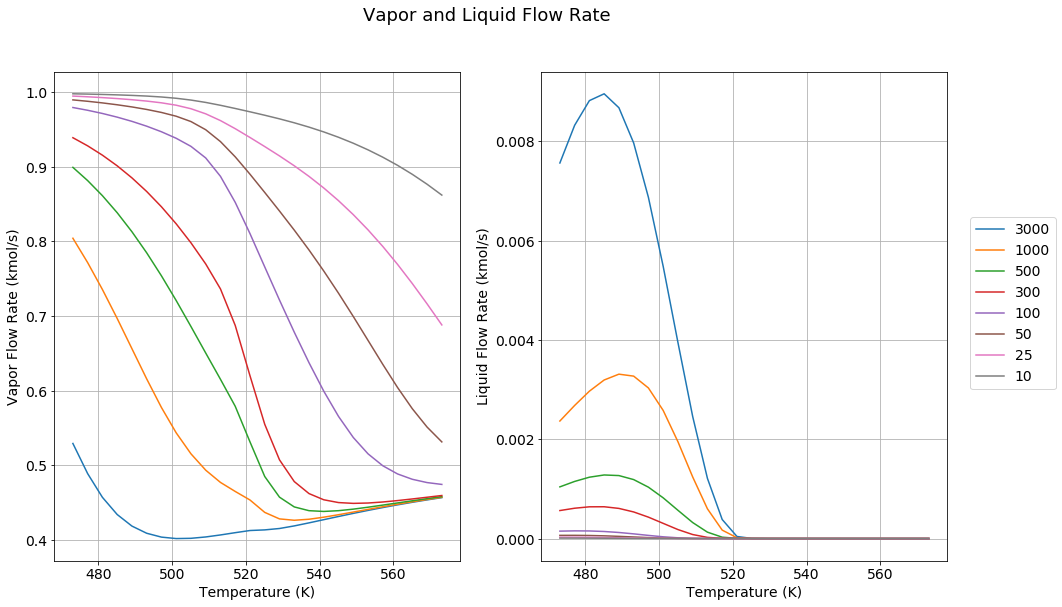

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['V'])
ax1.set_ylabel('Vapor Flow Rate (kmol/s)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.grid()

for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['L'])
ax2.set_ylabel('Liquid Flow Rate (kmol/s)',fontsize=14)
ax2.set_xlabel('Temperature (K)',fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid()

fig.legend(catrange,fontsize=14,loc=7)
fig.suptitle('Vapor and Liquid Flow Rate',fontsize=18)

plt.show()

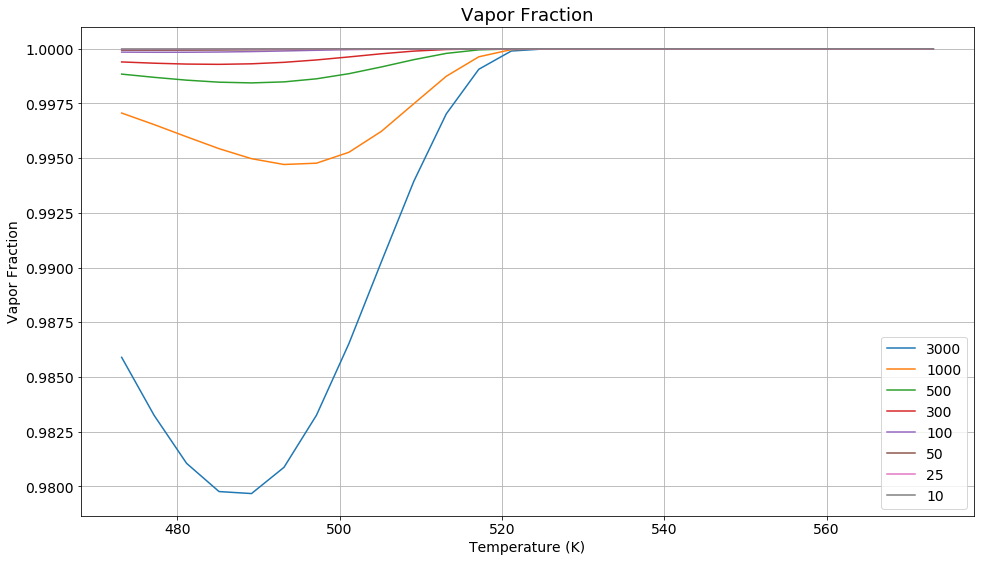

In [31]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.divide(rf_data_master[c]['V'],np.add(rf_data_master[c]['V'],rf_data_master[c]['L'])))
ax1.set_ylabel('Vapor Fraction',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title('Vapor Fraction',fontsize=18)
ax1.grid()
plt.show()

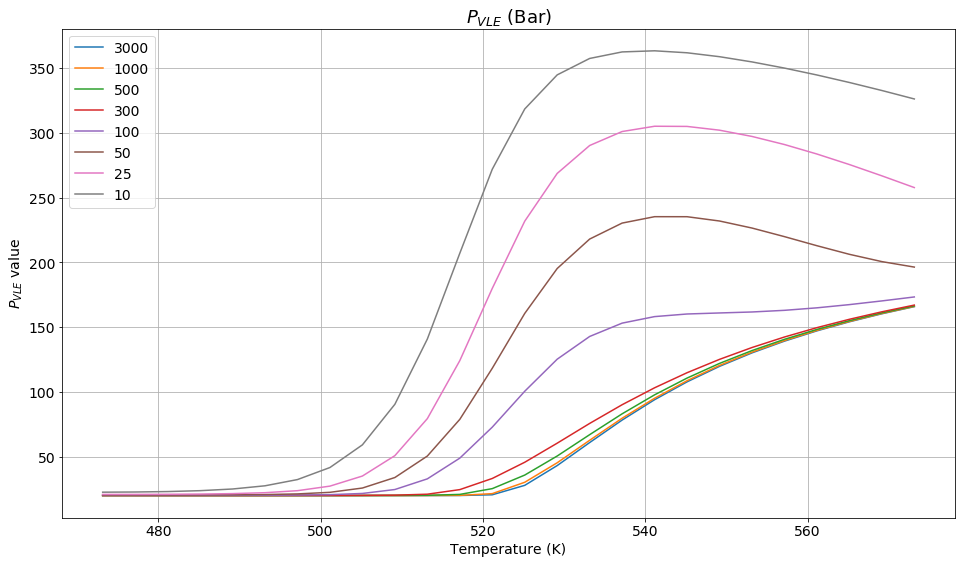

In [35]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['P_VLE'])
ax1.set_ylabel(r'$P_{VLE}$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title(r'$P_{VLE}$ (Bar)',fontsize=18)
ax1.grid()
plt.show()

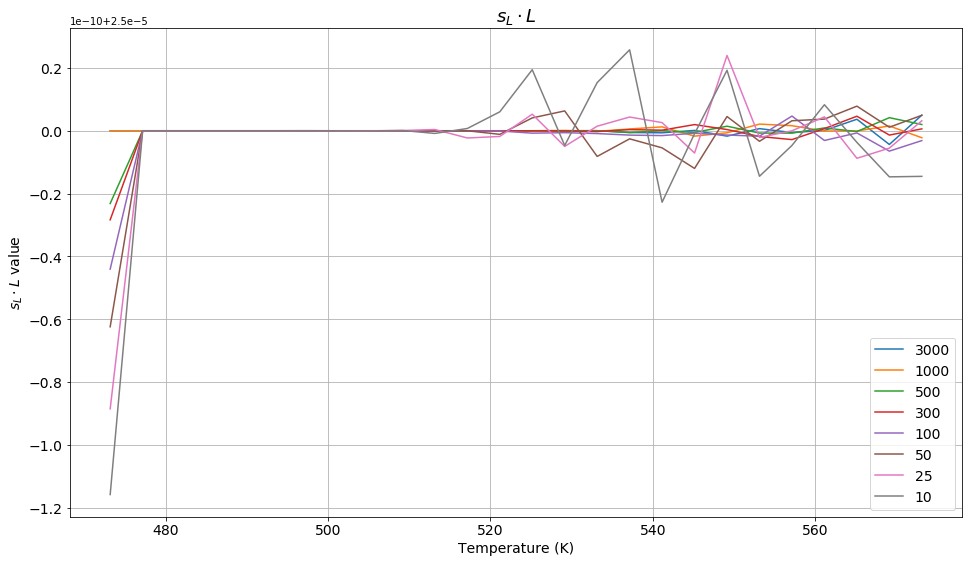

In [33]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.multiply(rf_data_master[c]['s_L'],rf_data_master[c]['L']))
ax1.set_ylabel(r'$s_L \cdot L$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
# ax1.set_ylim(2.49e-5,2.51e-5)
ax1.set_title(r'$s_L \cdot L$',fontsize=18)
ax1.grid()
plt.show()